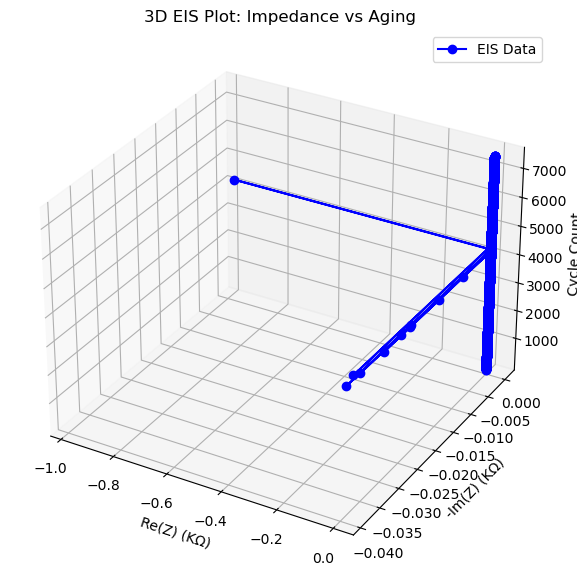

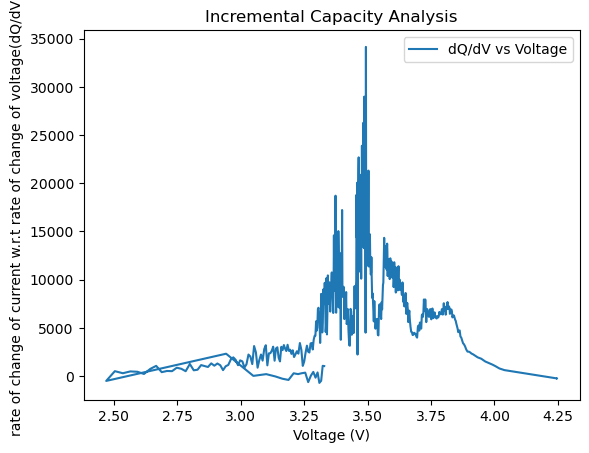

Mean Absolute Error: 0.06688247490847565


In [6]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
import os

metadata_path = "C:/Users/Dell/Desktop/programming/thingclock_batteryLabs/archive/cleaned_dataset/metadata.csv"
metadata_df = pd.read_csv(metadata_path)

impedance_data = metadata_df[metadata_df['type'] == 'impedance']
discharge_data = metadata_df[metadata_df['type'] == 'discharge']
impedance_real = np.array([complex(x).real for x in impedance_data['Re'].dropna().values])
impedance_imag = np.array([complex(x).imag for x in impedance_data['Rct'].dropna().values])

# Ensure cycle count is a numerical array
cycle_count = np.array(impedance_data.index.values, dtype=float)

# Drop NaN values in capacity and filter valid numeric values
capacity_filtered = discharge_data['Capacity'].dropna().astype(str)  # Convert to string temporarily
capacity_filtered = capacity_filtered[capacity_filtered.str.match(r'^[0-9]*\.?[0-9]+$')]  # Keep only numbers
capacity_filtered = capacity_filtered.astype(float)  # Convert back to float

# Ensure both X and y have the same number of rows
min_length = min(len(impedance_real), len(capacity_filtered))
impedance_real = impedance_real[:min_length]
impedance_imag = impedance_imag[:min_length]
cycle_count = cycle_count[:min_length]
capacity_filtered = capacity_filtered[:min_length]

X = np.column_stack((impedance_real, impedance_imag, cycle_count))
y = np.array(capacity_filtered)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Plotting Impedance Data
ax.plot(impedance_real, -impedance_imag, cycle_count, marker='o', linestyle='-', color='b', label="EIS Data")
ax.set_xlabel('Re(Z) (KΩ)')
ax.set_ylabel('-Im(Z) (KΩ)')
ax.set_zlabel('Cycle Count')
ax.set_title('3D EIS Plot: Impedance vs Aging')
plt.legend()
plt.show()

# Step 3: Compute dQ/dV for ICA Plot
discharge_file = os.path.join("C:/Users/Dell/Desktop/programming/thingclock_batteryLabs/archive/cleaned_dataset/data", discharge_data.iloc[0]['filename'])
discharge_df = pd.read_csv(discharge_file)
voltage = discharge_df['Voltage_measured']
charge = discharge_df['Current_measured'] * discharge_df['Time']
dQ_dV = np.gradient(charge, voltage)

plt.figure()
plt.plot(voltage, dQ_dV, label='dQ/dV vs Voltage')
plt.xlabel('Voltage (V)')
plt.ylabel('rate of change of current w.r.t rate of change of voltage(dQ/dV)')
plt.title('Incremental Capacity Analysis')
plt.legend()
plt.show()

# Step 4: Machine Learning Model for Capacity Prediction
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')